In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import random
import pandas as pd

In [2]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def xyt_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_t, t_i, t_f, N_bc):

    start = []
    end = []
    
    #Spatial array
    x_train = np.linspace(x_l, x_r, N_x)  
    y_train = np.linspace(y_b, y_t, N_y)
    x_train = np.repeat(x_train, N_y)
    y_train = np.tile(y_train, N_x)
    x_train = np.tile(x_train, N_t)
    y_train = np.tile(y_train, N_t)
    t_train = np.linspace(t_i, t_f, N_t)
    t_train = np.repeat(t_train, (N_x)*(N_y) )
    
    start.append( 0 )
    start.append( t_train.shape[0] )
    
    # Boundary collocation points
    x_bc1 = np.ones((N_bc))*x_l
    y_bc1 = np.linspace(y_b, y_t, N_bc)
    t_bc1 = np.linspace(t_i,t_f,N_t)
    x_bc1 = np.tile(x_bc1, N_t)
    y_bc1 = np.tile(y_bc1, N_t)
    t_bc1 = np.repeat(t_bc1, N_bc)
    
    start.append( start[-1] + t_bc1.shape[0] )
    
    x_bc2 = np.ones((N_bc))*x_r
    y_bc2 = np.linspace(y_b+0.001,y_t,N_bc)
    t_bc2 = np.linspace(t_i,t_f,N_t)
    x_bc2 = np.tile(x_bc2, N_t)
    y_bc2 = np.tile(y_bc2, N_t)
    t_bc2 = np.repeat(t_bc2, N_bc)
    
    start.append( start[-1] + t_bc2.shape[0] )
    
    x_bc3 = np.linspace(x_l,x_r,N_bc)
    y_bc3 = np.ones((N_bc))*y_b
    t_bc3 = np.linspace(t_i,t_f,N_t)
    x_bc3 = np.tile(x_bc3, N_t)
    y_bc3 = np.tile(y_bc3, N_t)
    t_bc3 = np.repeat(t_bc3, N_bc)
    
    start.append( start[-1] + t_bc3.shape[0] )
    
    x_bc4 = np.linspace(x_l+0.001,x_r,N_bc)
    y_bc4 = np.ones((N_bc))*y_t
    t_bc4 = np.linspace(t_i,t_f,N_t)
    x_bc4 = np.tile(x_bc4, N_t)
    y_bc4 = np.tile(y_bc4, N_t)
    t_bc4 = np.repeat(t_bc4, N_bc)
    
    start.append( start[-1] + t_bc4.shape[0] )
    
    y_bc5 = np.linspace(y_b,y_t,N_bc)
    t_bc5 = np.linspace(t_i,t_f,N_t)
    y_bc5 = np.tile(y_bc5, N_t)
    t_bc5 = np.repeat(t_bc5, N_bc)
    x_bc5 = np.linspace(x_l,x_r,N_bc)
    x_bc5 = np.tile(x_bc5, N_t)
    
    start.append( start[-1] + t_bc5.shape[0] )
    
    # np to torch
    
    x_T = np.concatenate((x_train, x_bc1, x_bc2, x_bc3, x_bc4), axis = 0)
    y_T = np.concatenate((y_train, y_bc1, y_bc2, y_bc3, y_bc4), axis = 0)
    t_T = np.concatenate((t_train, t_bc1, t_bc2, t_bc3, t_bc4), axis = 0)
    
    x_T = np_to_torch(x_T)
    y_T = np_to_torch(y_T)
    t_T = np_to_torch(t_T)

    x_s = np_to_torch(x_bc5)
    y_s = np_to_torch(y_bc5)
    t_s = np_to_torch(t_bc5)
    
    return x_T, y_T, t_T, x_s, y_s, t_s, start

def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.01)
    
class ANN(nn.Module):
    def __init__(self, layer_size_1, layer_size_2):
        super(ANN, self).__init__()

        softsign = nn.Softsign()
        tanh = nn.Tanh()
        # Fully conected model-1
        modules_11 = []
        modules_11.append(nn.Linear(layer_size_1[0], layer_size_1[1]))  
        modules_11.append(tanh)
        self.fc_11 = nn.Sequential( *modules_11 )
        modules_12 = []
        modules_12.append(nn.Linear(layer_size_1[1], layer_size_1[2])) 
        modules_12.append(tanh)
        modules_12.append(nn.Linear(layer_size_1[1], layer_size_1[2])) 
        modules_12.append(nn.Tanh())
        self.fc_12 = nn.Sequential( *modules_12 )
        modules_13 = []
        modules_13.append(nn.Linear(layer_size_1[2], layer_size_1[3])) 
        self.fc_13 = nn.Sequential( *modules_13 )

        for layer in [self.fc_11.modules(), self.fc_12.modules(), self.fc_13.modules()]:
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean=0.15, std=0.25)

        ############ NN2 #############
        modules_2 = []
        for i in range(len(layer_size_2) - 1):
            modules_2.append(nn.Linear(layer_size_2[i], layer_size_2[i+1]))  
            if i != len(layer_size_2) - 2 :
                modules_2.append(tanh)
        
        self.fc_2 = nn.Sequential(*modules_2)
        for layer in self.fc_2.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean= 0.1, std=0.2)

        ############ NN3 #############
        modules_3 = []
        for i in range(len(layer_size_2) - 1):
            modules_3.append(nn.Linear(layer_size_2[i], layer_size_2[i+1]))  
            if i != len(layer_size_2) - 2 :
                modules_3.append(tanh)
                
        self.fc_4 = nn.Sequential(*modules_3)
        for layer in self.fc_4.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean= 0.1, std=0.2)
    
    def forward(self, x_T, y_T, t_T, x_s, y_s, t_s, start):

        m = nn.Tanh()
        out_1 = self.fc_11( torch.cat((x_T, y_T, t_T),1) )
        out_2 = self.fc_12( out_1 )
        T = m(self.fc_13( out_1 + out_2 ))
        dTdx = torch.autograd.grad(T, x_T, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdx2 = torch.autograd.grad(dTdx, x_T, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
        dTdy = torch.autograd.grad(T, y_T, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdy2 = torch.autograd.grad(dTdy, y_T, grad_outputs=torch.ones_like(dTdy), create_graph=True)[0]
        dTdt = torch.autograd.grad(T, t_T, grad_outputs=torch.ones_like(T), create_graph=True)[0]

         ######### NN4 ########
        output1 = self.fc_4( t_T )
        a1 = output1[:,0].unsqueeze(-1)
        b1 = output1[:,1].unsqueeze(-1)
        c1 = output1[:,2].unsqueeze(-1)
        d1 = output1[:,3].unsqueeze(-1)
        e1 = output1[:,4].unsqueeze(-1)
        s_2 = torch.mul( a1, torch.pow(x_T, 4) ) + torch.mul( b1, torch.pow(x_T, 3) ) + torch.mul( c1, torch.pow(x_T, 2) ) + torch.mul( d1, torch.pow(x_T, 1) ) + e1
        
        output = self.fc_4( t_s )
        a = output[:,0].unsqueeze(-1)
        b = output[:,1].unsqueeze(-1)
        c = output[:,2].unsqueeze(-1)
        d = output[:,3].unsqueeze(-1)
        e = output[:,4].unsqueeze(-1)
        sy = torch.mul( a, torch.pow(x_s, 4) ) + torch.mul( b, torch.pow(x_s, 3) ) + torch.mul( c, torch.pow(x_s, 2) ) + torch.mul( d, torch.pow(x_s, 1) ) + e
        dsydx = torch.autograd.grad(sy, x_s, grad_outputs=torch.ones_like(sy), create_graph=True)[0]
        dsydt = torch.autograd.grad(sy, t_s, grad_outputs=torch.ones_like(sy), create_graph=True)[0]
        out_s1 = self.fc_11( torch.cat((x_s, sy, t_s), 1) )
        out_s2 = self.fc_12( out_s1 )
        Tsy = m(self.fc_13( out_s1 + out_s2 ))
        dTsdy = torch.autograd.grad(Tsy, sy, grad_outputs=torch.ones_like(Tsy), create_graph=True)[0]

        ######### NN2 ########
        output1 = self.fc_2( t_T )
        a1 = output1[:,0].unsqueeze(-1)
        b1 = output1[:,1].unsqueeze(-1)
        c1 = output1[:,2].unsqueeze(-1)
        d1 = output1[:,3].unsqueeze(-1)
        e1 = output1[:,4].unsqueeze(-1)
        s_1 = torch.mul( a1, torch.pow(y_T, 4) ) + torch.mul( b1, torch.pow(y_T, 3) ) + torch.mul( c1, torch.pow(y_T, 2) ) + torch.mul( d1, torch.pow(y_T, 1) ) + e1
        
        output = self.fc_2( t_s )
        a = output[:,0].unsqueeze(-1)
        b = output[:,1].unsqueeze(-1)
        c = output[:,2].unsqueeze(-1)
        d = output[:,3].unsqueeze(-1)
        e = output[:,4].unsqueeze(-1)
        sx = torch.mul( a, torch.pow(y_s, 4) ) + torch.mul( b, torch.pow(y_s, 3) ) + torch.mul( c, torch.pow(y_s, 2) ) + torch.mul( d, torch.pow(y_s, 1) ) + e
        dsxdy = torch.autograd.grad(sx, y_s, grad_outputs=torch.ones_like(sx), create_graph=True)[0]
        dsxdt = torch.autograd.grad(sx, t_s, grad_outputs=torch.ones_like(sx), create_graph=True)[0]
        out_s1 = self.fc_11( torch.cat((sx, y_s, t_s), 1) )
        out_s2 = self.fc_12( out_s1 )
        Tsx = m(self.fc_13( out_s1 + out_s2 ))
        dTsdx = torch.autograd.grad(Tsx, sx, grad_outputs=torch.ones_like(Tsx), create_graph=True)[0]

        ### matrix for interface boundary condition ###
        cal_x = torch.mul( a, torch.pow(sy, 4) ) + torch.mul( b, torch.pow(sy, 3) ) + torch.mul( c, torch.pow(sy, 2) ) + torch.mul( d, torch.pow(sy, 1) ) + e
        m1 = torch.where(cal_x <= x_s, 1, 0)
        Ns = torch.sum(m1) + 1

        # cal_x = torch.mul( a1, torch.pow(s_2, 4) ) + torch.mul( b1, torch.pow(s_2, 3) ) + torch.mul( c1, torch.pow(s_2, 2) ) + torch.mul( d1, torch.pow(s_2, 1) ) + e1
        # m2 = torch.logical_or(torch.where(x_T <= s_1, 1, 0), torch.where(y_T <= s_2, 1, 0) )
        # Ns2 = torch.sum(m2) + 1
        m2 = 1
        Ns2 = 1

        # print(Ns)
        
        return T, dTdx, dTdy, d2Tdx2, d2Tdy2, dTdt, sx, sy, s_1, s_2, dsxdy, dsydx, dsxdt, dsydt, Tsx, Tsy, dTsdx, dTsdy, m1, Ns, m2, Ns2
    
def get_loss(x_T, y_T, t_T, x_s, y_s, t_s, start, k1, k2, T_l, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, N_x, N_y, N_bc, N_t, mat_1):
 
    T, dTdx, dTdy, d2Tdx2, d2Tdy2, dTdt, sx, sy, s_1, s_2, dsxdy, dsydx, dsxdt, dsydt, Tsx, Tsy, dTsdx, dTsdy, m1, Ns, m2, Ns2 = model(x_T, y_T, t_T, x_s, y_s, t_s, start)
    
    # eq1 = w1*torch.sum( torch.mul( m2, torch.square( dTdt - k1*(d2Tdx2 + d2Tdy2) ) ) )/(Ns2)
    eq1 = w1*torch.sum( torch.square( (dTdt - k1*(d2Tdx2 + d2Tdy2))[ : start[1]] ) )/(start[1])
    eq2 = w2*torch.sum( torch.square( dsxdt + k2*dTsdx*( 1 + torch.square(dsxdy) ) ) )/(start[-1]-start[-2])
    eq3 = w3*torch.sum( torch.square( dsydt + k2*dTsdy*( 1 + torch.square(dsydx) ) ) )/(start[-1]-start[-2])
    
    bc1 = w4*torch.sum( torch.square( T[ start[1]:start[2] ] - T_l ) )/(start[2]-start[1])
    bc2 = w6*torch.sum( torch.square( T[ start[3]:start[4] ] - T_l  ) )/(start[4]-start[3])
    bc3 = w5*torch.sum( torch.square( dTdy[ start[4]:start[5] ] ) )/(start[5]-start[4])
    bc4 = w7*torch.sum( torch.square( dTdx[ start[2]:start[3] ]  ) )/(start[3]-start[2])
    bc5 = w8*torch.sum( torch.square( torch.mul( Tsx, m1 ) ) )/Ns
    bc6 = w9*torch.sum( torch.square( torch.mul( Tsy, m1 ) ) )/Ns

    ic1 = w10*torch.sum( torch.mul( mat_1, torch.square( T[0:N_x*N_y] ) ) )/(N_x*N_y)
    ic2 = w11*torch.sum( torch.square( sx[0:N_bc] - 0.05 ) )/(N_bc)
    ic3 = w12*torch.sum( torch.square( sy[0:N_bc] - 0.05 ) )/(N_bc)
    # p = torch.sum( torch.square( m(-40*sx) ) )/(N_bc)
    
    loss = eq1 + eq2 + eq3 + bc1 + bc2 + bc3 + bc4 + bc5 + bc6 + ic1 + ic2 + ic3 
    
    return loss, eq1, eq2, eq3, bc1, bc2, bc3, bc4, bc5, bc6, ic1, ic2, ic3

def print_loss(epoch, loss, eq1, eq2, eq3, bc1, bc2, bc3, bc4, bc5, bc6, ic1, ic2, ic3):
    print('epoch = ',epoch)
    print('loss = ',loss.detach().numpy())
    print('eq1_loss = ',eq1.detach().numpy())
    print('eq2_loss = ',eq2.detach().numpy())
    print('eq3_loss = ',eq3.detach().numpy())
    print('bc1_loss = ',bc1.detach().numpy())
    print('bc2_loss = ',bc2.detach().numpy())
    print('bc3_loss = ',bc3.detach().numpy())
    print('bc4_loss = ',bc4.detach().numpy())
    print('bc5_loss = ',bc5.detach().numpy())
    print('bc6_loss = ',bc6.detach().numpy())
    print('ic1_loss = ',ic1.detach().numpy())
    print('ic2_loss = ',ic2.detach().numpy())
    print('ic3_loss = ',ic3.detach().numpy())

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()

def freeze(model):
    for i, param in enumerate(model.parameters()):
        print("#######", i, " #######" )
        if i not in [4, 5, 10, 11]:
            param.requires_grad = False
        print(param)

In [3]:
N_x = 41
N_y = 41
N_t = 51
N_bc = 41

x_l = 0
y_b = 0
x_r = 0.4
y_t = 0.4

t_i = 0
t_f = 1
t = [t_i, t_f]

T_l = 0.4
T_r = 0

# material params
delta_T = 20
delta_x = 0.07
T_star = delta_T/T_l
x_star = delta_x/x_r
k1 = 1.29e-4/x_star**2
k2 = 1.08e-6*T_star/x_star**2
print('k1 = ',k1,' k2 = ', k2)

# Training data and initial data
layer_size_1 = [3, 8, 8, 1]
layer_size_2 = [1, 10, 10, 5]

model = ANN(layer_size_1, layer_size_2)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# Setup Loss function and Optimiser
epochs = 240001

k1 =  0.004212244897959182  k2 =  0.0017632653061224488
ANN(
  (fc_11): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): Tanh()
  )
  (fc_12): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
  )
  (fc_13): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
  (fc_2): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=5, bias=True)
  )
  (fc_4): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=5, bias=True)
  )
)
Total trainable parameters in the model: 555


In [4]:
N_x = 41
N_y = 41
N_t = 51
N_bc = 41

# Lists for storing
loss_store = []
lr1 = 1e-5
optimiser1 = torch.optim.Rprop(model.parameters(), lr=lr1)

# Load model
model.train()  
# path = 'model_0.12_12neurons_0mean_0.25std.pth'
# load_model(model, path)
# freeze(model)

# Loss function weights
w1 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1
w6 = 1
w7 = 1
w8 = 1
w9 = 1
w10 = 1
w11 = 30
w12 = 30

for i in range(0, len(t)-1):
    
    print('N_t = ', N_t)
    
    # Initial conditions
    x_T, y_T, t_T, x_s, y_s, t_s, start = xyt_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_t, t_i, t_f, N_bc)
    mat_1 = torch.mul( torch.mul( torch.where(x_T > x_l, 1, 0), torch.where(y_T > y_b, 1, 0) ), torch.where(t_T==0, 1, 0))
    mat_1 = mat_1[0:N_x*N_y]

    if(i>0):
        epochs = 7000
    for epoch in range(epochs):        
        #Backpropogation and optimisation
        loss, eq1, eq2, eq3, bc1, bc2, bc3, bc4, bc5, bc6, ic1, ic2, ic3 =  get_loss(x_T, y_T, t_T, x_s, y_s, t_s, start, k1, k2, T_l, w1, w2, w3, w4, 
                                                                                     w5, w6, w7, w8, w9, w10, w11, w12, N_x, N_y, N_bc, N_t, mat_1)
        loss_store.append(loss.detach().numpy())
        optimiser1.zero_grad()
        loss.backward()
        optimiser1.step()
    
        if epoch%100==0:
            print_loss(epoch, loss, eq1, eq2, eq3, bc1, bc2, bc3, bc4, bc5, bc6, ic1, ic2, ic3)
            print("")

N_t =  51
epoch =  0
loss =  13.313346
eq1_loss =  0.003198816
eq2_loss =  0.049882412
eq3_loss =  0.00049694034
bc1_loss =  0.6182832
bc2_loss =  0.59290224
bc3_loss =  0.0005298441
bc4_loss =  0.0038525641
bc5_loss =  0.13998517
bc6_loss =  0.122454226
ic1_loss =  0.113659985
ic2_loss =  0.122441016
ic3_loss =  11.545659

epoch =  100
loss =  0.11370681
eq1_loss =  0.004685751
eq2_loss =  2.389666e-05
eq3_loss =  0.0030350364
bc1_loss =  0.070714206
bc2_loss =  0.003770977
bc3_loss =  0.00020027257
bc4_loss =  0.00015700553
bc5_loss =  0.012183182
bc6_loss =  0.012146118
ic1_loss =  0.0064326916
ic2_loss =  3.1424588e-05
ic3_loss =  0.00032625356

epoch =  200
loss =  0.026586255
eq1_loss =  0.0047473423
eq2_loss =  0.0017151698
eq3_loss =  0.0016177506
bc1_loss =  0.003294383
bc2_loss =  0.0046772542
bc3_loss =  0.00016836674
bc4_loss =  7.94889e-05
bc5_loss =  0.0012254898
bc6_loss =  0.0016203063
ic1_loss =  0.0070460937
ic2_loss =  0.0001802073
ic3_loss =  0.00021440427

epoch = 

KeyboardInterrupt: 

In [ ]:
plt.plot(loss_store)

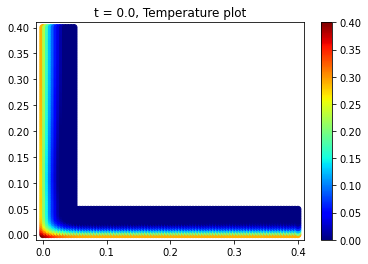

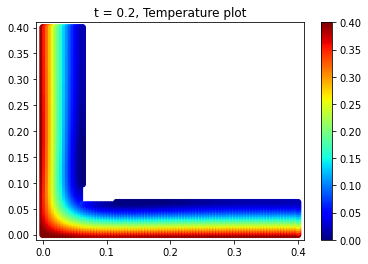

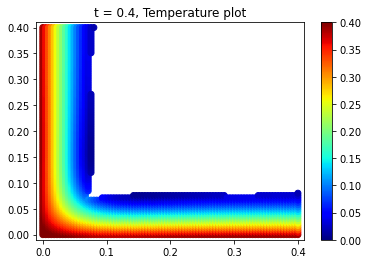

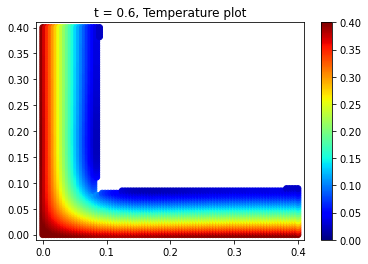

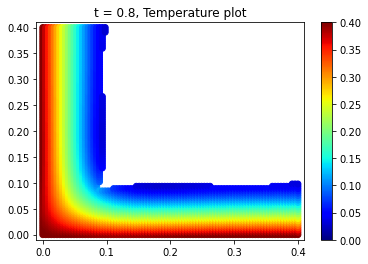

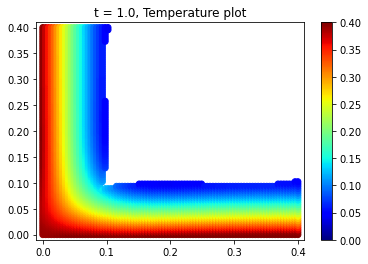

In [5]:
######################### Compute Results ###########################

N_x = 91
N_y = 91
N_bc = 91
x_T, y_T, t_T, x_s, y_s, t_s, start = xyt_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_t, t_i, t_f, N_bc)
T, dTdx, dTdy, d2Tdx2, d2Tdy2, dTdt, sx, sy, s_1, s_2, dsxdy, dsydx, dsxdt, dsydt, Tsx, Tsy, dTsdx, dTsdy, m1, Ns, m2, Ns = model(x_T, y_T, t_T, x_s, y_s, t_s, start)

X = x_T.detach().numpy()
Y = y_T.detach().numpy()
t = t_T.detach().numpy()
T = T.detach().numpy()
sy = s_2.detach().numpy()
sx = s_1.detach().numpy()
y_s = y_s.detach().numpy()

T_disp = []
X_disp = []
Y_disp = []
cnt = 0

for i in range(N_t):
    x_tp = []
    y_tp = []
    T_tp = []
    for j in range(N_x*N_y):
        # if X[cnt]<s[cnt]:
        if Y[cnt]<=sy[cnt] or  X[cnt]<=sx[cnt]:
            x_tp.append(X[cnt])
            y_tp.append(Y[cnt])
            T_tp.append(T[cnt])
        cnt = cnt + 1
    T_disp.append(T_tp)
    X_disp.append(x_tp)
    Y_disp.append(y_tp)

del_t = (t_f - t_i)/(N_t - 1)
for k in range(N_t):

    if k%10==0:
        plt.figure()
        sc = plt.scatter(X_disp[k], Y_disp[k], c=T_disp[k], cmap=plt.cm.jet)
        plt.clim(0,T_l)
        plt.xlim(x_l-0.01, x_r+0.01)
        plt.ylim(y_b-0.01, y_t+0.01)
        plt.colorbar(sc)
        plt.title('t = '+ str( round( k*del_t, 3) )+', Temperature plot')

plt.show()

In [ ]:
for k in range(N_t):

    if k%10==0:
        plt.figure()
        plt.plot( sx[ k*(N_bc):(k+1)*(N_bc) ], y_s[ k*(N_bc):(k+1)*(N_bc) ])
        plt.xlim(0, x_r)
        plt.ylim(0, y_t)
        plt.title('t = '+ str( round( t[k*(N_x*N_y)][0], 3) )+', Temperature plot')
        k = k+1

plt.show()

In [ ]:
u = X
u = u.squeeze(axis = 1)
u = u.reshape(N_x, N_y)
u = u.T
u = u.reshape(N_x*N_y)

v = Y
v = v.squeeze(axis = 1)
v = v.reshape(N_y, N_x)
v = v.T
v = v.reshape(N_x*N_y)

T_comp = []

for k in [21, 31, 41, 51]:

    T_temp = T[ k*(N_x*N_y):(k+1)*(N_x*N_y) ]
    T_temp = T_temp.squeeze(axis = 1)
    T_temp = T_temp.reshape(N_x, N_y)
    T_temp = T_temp.T
    T_temp = T_temp.reshape(N_x*N_y)
    T_comp.append(T_temp)

In [ ]:
plt.figure()
k = 0
sc = plt.scatter(u, v, c=T_comp[ k ], cmap=plt.cm.jet)
plt.clim(0,T_l)
plt.colorbar(sc)
plt.title('t = '+ str( round( t[k*(N_x*N_y)][0], 3) )+', Temperature plot')

In [ ]:
boom = pd.DataFrame(T_comp)
boom = boom.T
for i in range(N_x*N_y):
    print('x = ' , u[i], ' y = ', v[i], 'temp = ', boom.iloc[i][2])

In [ ]:
boom.to_excel("PINN.xlsx")

In [ ]:
u

In [ ]:
# x_T, y_T, t_T, y_s, t_s, start = xyt_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_t, t_i, t_f, N_bc)